In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# Double DQN - Double Q-Learning Implementation with Deep Neural Network

Double DQN is proposed in H. van Hasselt, 2016 of Google Deep Mind, inspired by Double Q-Learning, Double DQN uses two different Deep Neural Networks, Deep Q Network (DQN) and Target Network.

https://arxiv.org/pdf/1509.06461.pdf

In fundamental Q-learning, the Agent's optimal strategy involves selecting the most favorable action in any given state, based on the assumption that this action possesses the highest expected/estimated Q-value. However, since the Agent lacks knowledge about the environment initially, it must initially estimate Q(s, a) and update these estimates iteratively. These Q-values are prone to considerable noise, making it uncertain whether the action with the maximum expected/estimated Q-value is genuinely the best choice.

Regrettably, the action deemed optimal often yields smaller Q-values compared to non-optimal actions in many instances. In accordance with the basic Q-learning policy, the Agent tends to opt for non-optimal actions in a given state simply because they have higher Q-values. This issue is known as the overestimation of action value (Q-value).

When this problem arises, the noise from the estimated Q-value introduces substantial positive biases in the updating procedure. Consequently, the learning process becomes intricate and disorderly.

#### The idea of double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. In the vanilla implementation, the action selection and action evaluation are coupled. We use the target-network to select the action and estimate the quality of the action at the same time.

#### Double Q-learning tries to decouple these procedures from one another by separting the action selection and action evaluation in two different deep neural networks (see note cell #7 - DQN Class).


In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

from typing import Dict, List, Tuple

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

In [2]:
env = gym.make("Blackjack-v1", sab=False)
done = False
observation, info = env.reset()

In [3]:
class ReplayBuffer: 
    "Simple Numpy replay buffer"
    
    def __init__(self, obs_dim: int, size: int, batch_size: int=32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0
        
    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace = False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                   )
    def __len__(self) -> int:
        return self.size

In [4]:
class Network(nn.Module):
    def __init__(self,in_dim: int, out_dim: int):
        super(Network,self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation"""
        return self.layers(x)

In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """
    
    def __init__(
        self,
        memory_size: int,
        batch_size: int,
        target_update: int, 
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        
        obs_dim  = len(env.observation_space)
        action_dim = env.action_space.n
        
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.obs_accs = {}
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # Double DQN implementation, two networks are created, one for action selection
        # and the other for action evaluation
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        #optimizer 
        self.optimizer = optim.Adam(self.dqn.parameters(),lr=0.01,)
        
        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False
        
        
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state"""
        #epsilon greedy policy, randomly choose whether to be exploratory...
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            # select state using the learned policy from the ANN network
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            print(self.dqn(
                torch.FloatTensor(state).to(self.device)
            ))
            selected_action = selected_action.detach().cpu().numpy()
            
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()
        
        loss = self._compute_dqn_loss(samples)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
        
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss"""
        
        device = self.device # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).reshape(-1,1).to(device)
        reward = torch.FloatTensor(samples["rews"]).reshape(-1,1).to(device)
        done = torch.FloatTensor(samples["done"]).reshape(-1,1).to(device)
        
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        
        
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        
        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)
        
        return loss
        
    def _target_hard_update(self):
        """Hard update: target <- local"""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        
        
    def _plot(
        self,
        episode: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('episode %s. score: %s' % (episode, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

In [6]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
np.random.seed(seed)
seed_torch(seed)

In [7]:
n_episodes = 10000
start_epsilon = 1.0
memory_size = 10000
batch_size = 128
target_update = 2000
epsilon_decay = start_epsilon / (n_episodes / 2) # reduces the exploration over time

agent = DQNAgent(memory_size, batch_size, target_update, epsilon_decay)

cpu


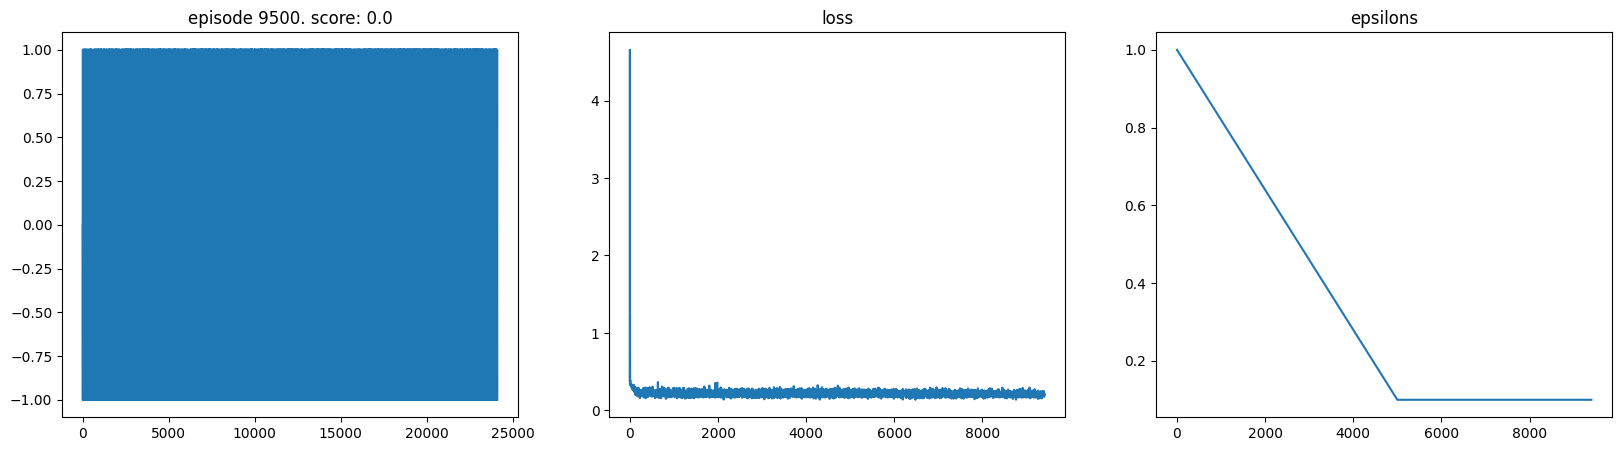

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 232.86it/s]


In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

losses = []
scores = []
epsilons = []

obs_accs = []

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    score = 0
    update_cnt = 0
    plotting_interval = 500
    
    # play one episode
    while not done:
        selected_action = 0
        
        record = 0
        
        #epsilon greedy policy, randomly choose whether to be exploratory...kinda irresponsible.
        if agent.epsilon > np.random.random():
            selected_action = env.action_space.sample()
            record = selected_action
            agent.obs_accs[obs] = selected_action
        else:
            # select state using the learned policy from the ANN network
            selected_action = agent.dqn(
                torch.FloatTensor(obs).to(agent.device)
            ).argmax()
            
            record = agent.dqn(
                torch.FloatTensor(obs).to(agent.device)
            ).detach().numpy()
            
            agent.obs_accs[obs] = record
            
            selected_action = selected_action.detach().cpu().numpy()
            
        if not agent.is_test:
            agent.transition = [obs, selected_action]
            
        obs_accs.append([obs,record])
        
        next_obs, reward, terminated, truncated, info = env.step(selected_action)
        done = terminated or truncated
        obs = next_obs
        
        if not agent.is_test:
            agent.transition += [reward, next_obs, done]
            agent.memory.store(*agent.transition)
        

        scores.append(score)
        score += reward
        
        if done:
            obs, _ = env.reset()
            scores.append(score)
            score = 0
                
            # if training is ready
            if len(agent.memory) >= agent.batch_size:
                loss = agent.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                agent.epsilon = max(
                    agent.min_epsilon, agent.epsilon - (
                        agent.max_epsilon - agent.min_epsilon
                    ) * agent.epsilon_decay
                )
                epsilons.append(agent.epsilon)
                
            # if hard update is needed
            if update_cnt % agent.target_update == 0:
                agent._target_hard_update()
                
            if episode % plotting_interval == 0:
                agent._plot(episode, scores, losses, epsilons)
        
        

    

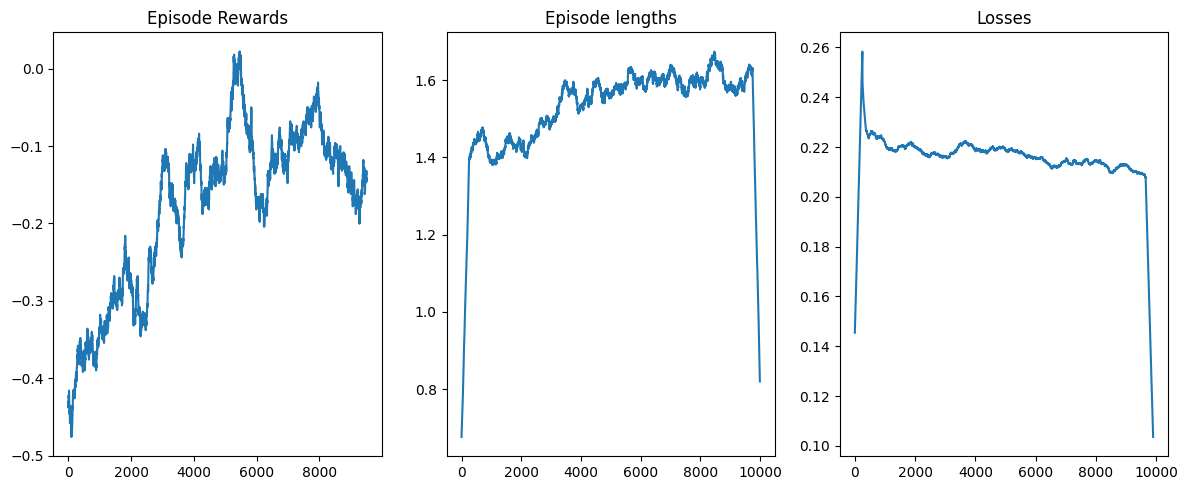

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
axs[0].set_title("Episode Rewards")

# compute and assign a rolling average of the data to provide a smoother graph

reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(),np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)

axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Losses")
training_error_moving_average = (
    np.convolve(np.array(losses), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [10]:
state_value = defaultdict(float)
policy = defaultdict(int)
    
for obs, action_values in agent.obs_accs.items():
    state_value[obs] = float(np.max(action_values))
    policy[obs] = int(np.argmax(action_values))

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    
    state_value = defaultdict(float)
    policy = defaultdict(int)
    
    for obs, action_values in agent.obs_accs.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))
    
    player_count, dealer_count = np.meshgrid(
        np.arange(12,22),
        np.arange(1,11)
    )
    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

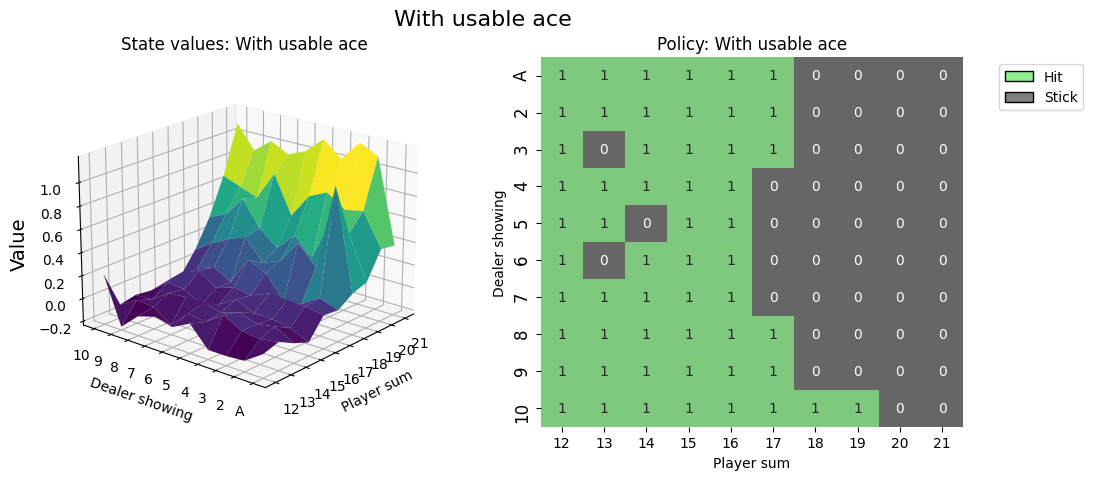

In [12]:
def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

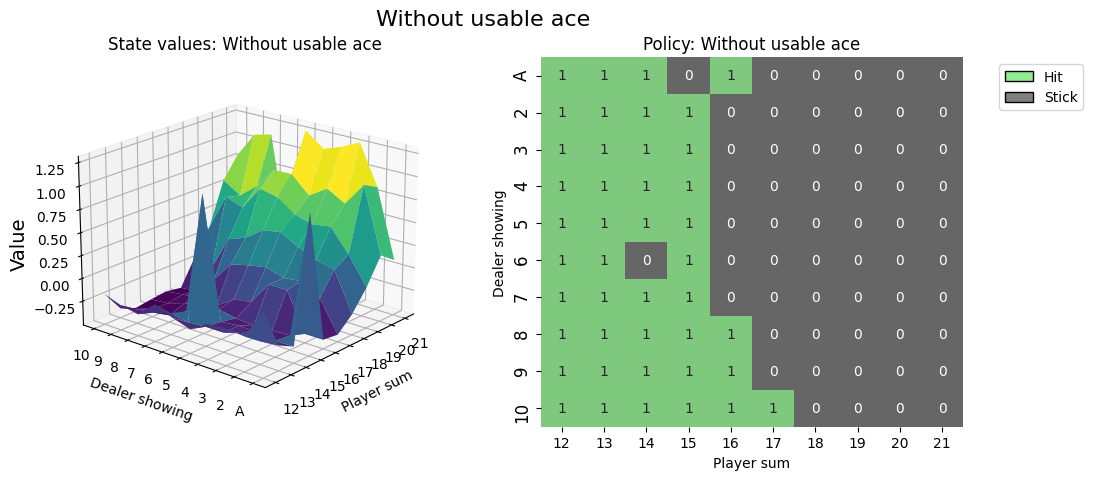

In [13]:
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()